<a href="https://colab.research.google.com/github/Tonge-Shim/1/blob/master/Train_BoneClassification_chaeeun_1970052.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset, random_split

데이터를 train, validation으로 4:1로 나눠서 넣기.
shuffle?g
flip? -> data augmentation?


In [ ]:
# Paths for training & validation data. 
# You should create './PatternProject/Train or Validation' folders in your google drive
train_path = '/content/drive/My Drive/PatternProject/Train/' 
valid_path = '/content/drive/My Drive/PatternProject/Validation/'


In [ ]:
#Prepare training data set
classes = ['Normal','Fracture']

data =[]
label =[]
resize = transforms.Compose([transforms.CenterCrop(400)]) #crop to 400

for i, d in enumerate(classes):#0: Normal, 1: Fracture
    files = os.listdir(train_path+d)#해당 디렉터리에 있는 파일들의 리스트를 얻을 수 있다.
    #train_path/Normal, train_path/Fracture
    for f in files:
        img = Image.open(train_path+d+'/'+f,'r')#trainpath/Normal/파일이름, read mode
        img = resize(img)
        r,g,b = img.split() # same levels

        one_img = np.asarray(np.float32(r)/255.0) #choose one
        img = np.asarray([one_img])

        # imgaug = np.fliplr(img)
        # imgaug2 = np.flipud(img)
        # imgaug3 = np.rot90(img,2)
        
        data.append(img)#data에 추가
        # data.append(imgaug)
        # data.append(imgaug2)
        # data.append(imgaug3)
        
        label.append(i)#0,1 label list
        # label.append(i)
        # label.append(i)
        # label.append(i)
        
        

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
#Prepare validation data set

data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+d)
    
    for f in files:
        img = Image.open(valid_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split()
        one_img = np.asarray(np.float32(r)/255.0)
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [ ]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

        
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.LeakyReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.act(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

class semiGoogLeNet(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(semiGoogLeNet, self).__init__()
      
        self.conv1 = ConvBlock(1, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception1 = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
    
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception2 = InceptionModule(in_channels=256,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        #self.aux2 = InceptionAux(512, num_classes) 
        self.inception3 = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)

        self.inception4 = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        #self.aux4 = InceptionAux(528, num_classes)

        self.inception5 = InceptionModule(in_channels=528 ,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception6 = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        
        self.pool5 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(1024, num_classes)
        #self.fc = nn.Linear(512, num_classes)
        
        


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.inception1(x)
        x = self.pool3(x)
        x = self.inception2(x)
  

        # aux1 = self.aux2(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
  
        #aux2 = self.aux4(x)
        
        x = self.inception5(x)
        x = self.pool4(x)
        x = self.inception6(x)
        x = self.pool5(x)#avg
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        return x#, aux1, aux2

model = semiGoogLeNet()

In [ ]:
#3
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1,16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding = 1)
        self.fc1 = nn.Linear(50*50*16, 400)
        self.fc2 = nn.Linear(400, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        
        out = F.max_pool2d(torch.tanh(self.conv3(out)) , 2)
        out = out.view(-1, 50*50*16)

        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
model = Net()

In [ ]:
# Print the network you built
model.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=40000, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=2, bias=True)
)

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()

        output = model(inputs)

        idx, pred = output.max(1)

        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
#################################################################
        # prediction0, prediction1, prediction2 = model(inputs)
        # idx, pred = prediction0.max(1)

        # pred = (pred.detach().cpu().numpy())
        # truth = (labels.detach().cpu().numpy())
        #     # Compute the loss.
        # loss0 = criterion(prediction0, labels)
        # loss1 = criterion(prediction1, labels)
        # loss2 = criterion(prediction2, labels)
            
        # loss = loss0 + 0.3 * loss1 + 0.4 * loss2
        #     # Backward pass.
        # loss.backward()

####################################################################
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        #prediction0, prediction1, prediction2 = model(inputs)
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        #print('Valid_Prediction : {}'.format(pred))
        #print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        # loss0 = criterion(prediction0, labels)
        # loss1 = criterion(prediction1, labels)
        # loss2 = criterion(prediction2, labels)
            
        #loss = loss0 + 0.3 * loss1 + 0.4 * loss2
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /100
Train Accuracy : 54.08163265306123
Validation Accuracy : 52.54237288135594
# Epoch : 1 /100
Train Accuracy : 54.08163265306123
Validation Accuracy : 61.016949152542374
# Epoch : 2 /100
Train Accuracy : 55.78231292517006
Validation Accuracy : 50.847457627118644
# Epoch : 3 /100
Train Accuracy : 53.74149659863946
Validation Accuracy : 59.32203389830508
# Epoch : 4 /100
Train Accuracy : 56.12244897959183
Validation Accuracy : 57.6271186440678
# Epoch : 5 /100
Train Accuracy : 54.08163265306123
Validation Accuracy : 55.932203389830505
# Epoch : 6 /100
Train Accuracy : 60.544217687074834
Validation Accuracy : 57.6271186440678
# Epoch : 7 /100
Train Accuracy : 58.843537414965986
Validation Accuracy : 54.23728813559322
# Epoch : 8 /100
Train Accuracy : 56.12244897959183
Validation Accuracy : 61.016949152542374
# Epoch : 9 /100
Train Accuracy : 56.4625850340136
Validation Accuracy : 55.932203389830505


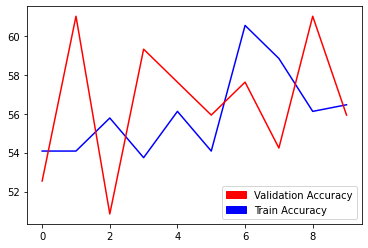

# Epoch : 10 /100
Train Accuracy : 58.16326530612245
Validation Accuracy : 59.32203389830508
# Epoch : 11 /100
Train Accuracy : 59.523809523809526
Validation Accuracy : 55.932203389830505
# Epoch : 12 /100
Train Accuracy : 58.16326530612245
Validation Accuracy : 57.6271186440678
# Epoch : 13 /100
Train Accuracy : 59.183673469387756
Validation Accuracy : 57.6271186440678
# Epoch : 14 /100
Train Accuracy : 60.544217687074834
Validation Accuracy : 54.23728813559322
# Epoch : 15 /100
Train Accuracy : 57.14285714285714
Validation Accuracy : 62.71186440677966
# Epoch : 16 /100
Train Accuracy : 57.82312925170068
Validation Accuracy : 57.6271186440678
# Epoch : 17 /100
Train Accuracy : 59.523809523809526
Validation Accuracy : 55.932203389830505
# Epoch : 18 /100
Train Accuracy : 58.843537414965986
Validation Accuracy : 59.32203389830508
# Epoch : 19 /100
Train Accuracy : 58.16326530612245
Validation Accuracy : 61.016949152542374


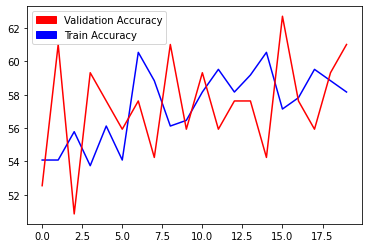

# Epoch : 20 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 62.71186440677966
# Epoch : 21 /100
Train Accuracy : 57.82312925170068
Validation Accuracy : 61.016949152542374
# Epoch : 22 /100
Train Accuracy : 57.48299319727891
Validation Accuracy : 57.6271186440678
# Epoch : 23 /100
Train Accuracy : 58.16326530612245
Validation Accuracy : 52.54237288135594
# Epoch : 24 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 61.016949152542374
# Epoch : 25 /100
Train Accuracy : 60.544217687074834
Validation Accuracy : 54.23728813559322
# Epoch : 26 /100
Train Accuracy : 58.50340136054422
Validation Accuracy : 61.016949152542374
# Epoch : 27 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 57.6271186440678
# Epoch : 28 /100
Train Accuracy : 63.94557823129252
Validation Accuracy : 55.932203389830505
# Epoch : 29 /100
Train Accuracy : 63.60544217687075
Validation Accuracy : 55.932203389830505


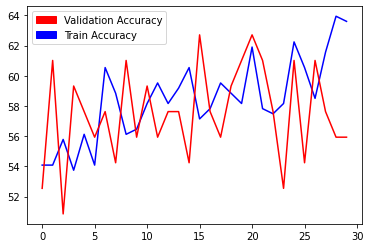

# Epoch : 30 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 57.6271186440678
# Epoch : 31 /100
Train Accuracy : 56.4625850340136
Validation Accuracy : 62.71186440677966
# Epoch : 32 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 57.6271186440678
# Epoch : 33 /100
Train Accuracy : 62.925170068027214
Validation Accuracy : 61.016949152542374
# Epoch : 34 /100
Train Accuracy : 59.863945578231295
Validation Accuracy : 57.6271186440678
# Epoch : 35 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 57.6271186440678
# Epoch : 36 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 57.6271186440678
# Epoch : 37 /100
Train Accuracy : 58.843537414965986
Validation Accuracy : 59.32203389830508
# Epoch : 38 /100
Train Accuracy : 60.204081632653065
Validation Accuracy : 61.016949152542374
# Epoch : 39 /100
Train Accuracy : 60.204081632653065
Validation Accuracy : 55.932203389830505


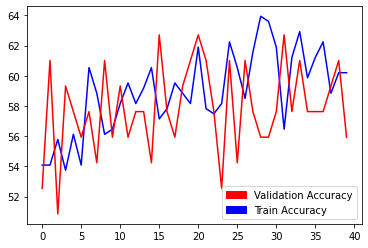

# Epoch : 40 /100
Train Accuracy : 59.863945578231295
Validation Accuracy : 59.32203389830508
# Epoch : 41 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 59.32203389830508
# Epoch : 42 /100
Train Accuracy : 58.843537414965986
Validation Accuracy : 57.6271186440678
# Epoch : 43 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 59.32203389830508
# Epoch : 44 /100
Train Accuracy : 64.28571428571429
Validation Accuracy : 55.932203389830505
# Epoch : 45 /100
Train Accuracy : 62.925170068027214
Validation Accuracy : 55.932203389830505
# Epoch : 46 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 59.32203389830508
# Epoch : 47 /100
Train Accuracy : 62.585034013605444
Validation Accuracy : 59.32203389830508
# Epoch : 48 /100
Train Accuracy : 60.544217687074834
Validation Accuracy : 59.32203389830508
# Epoch : 49 /100
Train Accuracy : 63.26530612244898
Validation Accuracy : 54.23728813559322


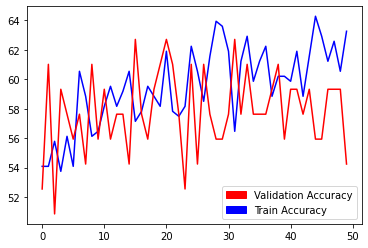

# Epoch : 50 /100
Train Accuracy : 62.925170068027214
Validation Accuracy : 55.932203389830505
# Epoch : 51 /100
Train Accuracy : 60.204081632653065
Validation Accuracy : 55.932203389830505
# Epoch : 52 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 55.932203389830505
# Epoch : 53 /100
Train Accuracy : 63.94557823129252
Validation Accuracy : 57.6271186440678
# Epoch : 54 /100
Train Accuracy : 60.8843537414966
Validation Accuracy : 54.23728813559322
# Epoch : 55 /100
Train Accuracy : 59.863945578231295
Validation Accuracy : 61.016949152542374
# Epoch : 56 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 55.932203389830505
# Epoch : 57 /100
Train Accuracy : 63.26530612244898
Validation Accuracy : 54.23728813559322
# Epoch : 58 /100
Train Accuracy : 63.26530612244898
Validation Accuracy : 57.6271186440678
# Epoch : 59 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 61.016949152542374


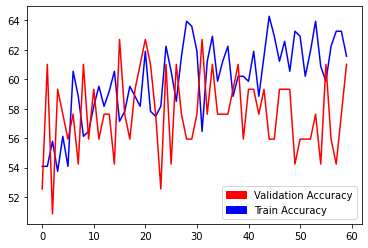

# Epoch : 60 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 57.6271186440678
# Epoch : 61 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 57.6271186440678
# Epoch : 62 /100
Train Accuracy : 65.98639455782312
Validation Accuracy : 54.23728813559322
# Epoch : 63 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 57.6271186440678
# Epoch : 64 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 59.32203389830508
# Epoch : 65 /100
Train Accuracy : 64.28571428571429
Validation Accuracy : 59.32203389830508
# Epoch : 66 /100
Train Accuracy : 60.8843537414966
Validation Accuracy : 57.6271186440678
# Epoch : 67 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 59.32203389830508
# Epoch : 68 /100
Train Accuracy : 62.585034013605444
Validation Accuracy : 57.6271186440678
# Epoch : 69 /100
Train Accuracy : 58.50340136054422
Validation Accuracy : 57.6271186440678


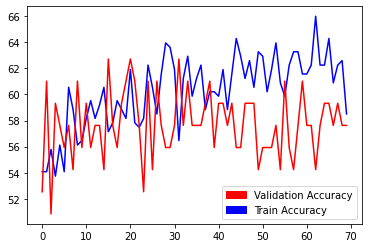

# Epoch : 70 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 59.32203389830508
# Epoch : 71 /100
Train Accuracy : 63.94557823129252
Validation Accuracy : 54.23728813559322
# Epoch : 72 /100
Train Accuracy : 62.925170068027214
Validation Accuracy : 57.6271186440678
# Epoch : 73 /100
Train Accuracy : 62.925170068027214
Validation Accuracy : 57.6271186440678
# Epoch : 74 /100
Train Accuracy : 64.96598639455783
Validation Accuracy : 57.6271186440678
# Epoch : 75 /100
Train Accuracy : 61.564625850340136
Validation Accuracy : 57.6271186440678
# Epoch : 76 /100
Train Accuracy : 60.544217687074834
Validation Accuracy : 57.6271186440678
# Epoch : 77 /100
Train Accuracy : 62.585034013605444
Validation Accuracy : 59.32203389830508
# Epoch : 78 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 59.32203389830508
# Epoch : 79 /100
Train Accuracy : 63.60544217687075
Validation Accuracy : 57.6271186440678


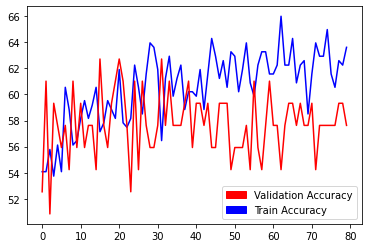

# Epoch : 80 /100
Train Accuracy : 64.28571428571429
Validation Accuracy : 59.32203389830508
# Epoch : 81 /100
Train Accuracy : 63.26530612244898
Validation Accuracy : 62.71186440677966
# Epoch : 82 /100
Train Accuracy : 63.26530612244898
Validation Accuracy : 57.6271186440678
# Epoch : 83 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 59.32203389830508
# Epoch : 84 /100
Train Accuracy : 60.8843537414966
Validation Accuracy : 59.32203389830508
# Epoch : 85 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 64.40677966101694
# Epoch : 86 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 61.016949152542374
# Epoch : 87 /100
Train Accuracy : 63.60544217687075
Validation Accuracy : 55.932203389830505
# Epoch : 88 /100
Train Accuracy : 64.28571428571429
Validation Accuracy : 55.932203389830505
# Epoch : 89 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 55.932203389830505


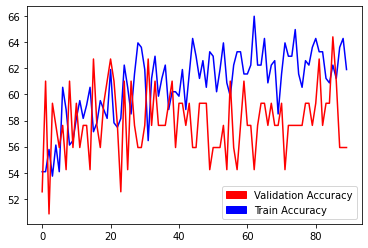

# Epoch : 90 /100
Train Accuracy : 63.94557823129252
Validation Accuracy : 59.32203389830508
# Epoch : 91 /100
Train Accuracy : 61.224489795918366
Validation Accuracy : 59.32203389830508
# Epoch : 92 /100
Train Accuracy : 65.98639455782312
Validation Accuracy : 55.932203389830505
# Epoch : 93 /100
Train Accuracy : 65.64625850340136
Validation Accuracy : 59.32203389830508
# Epoch : 94 /100
Train Accuracy : 64.62585034013605
Validation Accuracy : 54.23728813559322
# Epoch : 95 /100
Train Accuracy : 63.60544217687075
Validation Accuracy : 59.32203389830508
# Epoch : 96 /100
Train Accuracy : 62.244897959183675
Validation Accuracy : 57.6271186440678
# Epoch : 97 /100
Train Accuracy : 63.60544217687075
Validation Accuracy : 57.6271186440678
# Epoch : 98 /100
Train Accuracy : 61.904761904761905
Validation Accuracy : 55.932203389830505
# Epoch : 99 /100
Train Accuracy : 64.96598639455783
Validation Accuracy : 61.016949152542374


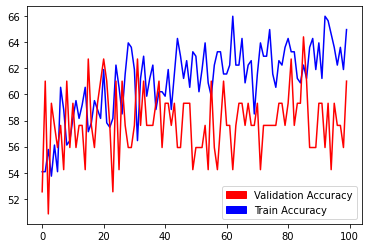

In [ ]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(100):
    print('# Epoch : {} /100'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)
    if (epoch+1)%10 == 0:
        plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
        blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
        red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
        plt.legend(handles=[red_patch, blue_patch])
        plt.show()

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/My Drive/PatternProject/Model_chaeeun_1970052')

flipping imgs
> https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/